In [1]:
import pandas as pd
import numpy as np
import time

from scipy import stats

import matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegressionCV, SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD

%matplotlib inline

In [2]:
df = pd.read_csv("imdb_data/IMDB Dataset.csv")

df['review'] = df['review'].str.replace("<br /><br />", " ").str.replace('\u200b', '').str.strip()

In [3]:
# X contains text contents of reviews, y contains labeled sentiment
X = df['review']
y = df['sentiment']

In [4]:
# split the data into training, testing and validation data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [5]:
# record start time of data training model
start_time = time.perf_counter()

# tfidf vectorizer using character n-grams (with bounds), n-gram range of 3-6 letters, and keep words in vocab that appear at least 5 times
vectorizer = TfidfVectorizer(analyzer='char_wb', ngram_range=(3,6), min_df=5)
X_train_vectors = vectorizer.fit_transform(X_train)
X_test_vectors = vectorizer.transform(X_test)

# dimensionality reduction of sparce vectors from vectorization
# convert sparse vectors into dense word embedding vectors
# somewhat of an imitation of fasttext's word embedding hidden layer
svd = TruncatedSVD(n_components=300, random_state=42)
X_train_dense = svd.fit_transform(X_train_vectors)
X_test_dense = svd.transform(X_test_vectors)

# scale resulting data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_dense)
X_test_scaled = scaler.transform(X_test_dense)

# get total time taken to train and scale
end_time = time.perf_counter()
initial_elapsed_time = end_time - start_time

print("Time Taken to Train and Scale Raw Text Data:")
print(str(initial_elapsed_time) + " Seconds")

Time Taken to Train and Scale Raw Text Data:
316.9778776 Seconds


In [6]:
# initialize time and model accuracy lists
times = []
accuracies = []

In [7]:
# C values to try in logistic regression
cs = np.logspace(-4, 3, num=80)

# record start time of training and predicting model
start_time = time.perf_counter()

# logistic regression with augmented stochastic average gradient
logisticcv_clf = LogisticRegressionCV(solver='saga', Cs=cs, max_iter=1000, n_jobs=-1)
logisticcv_clf.fit(X_train_scaled, y_train)
y_pred = logisticcv_clf.predict(X_test_scaled)

# get total time taken to train model and predict
end_time = time.perf_counter()
elapsed_time = end_time - start_time
times.append(elapsed_time + initial_elapsed_time)

accuracies.append(accuracy_score(y_test, y_pred))

print("Tuned Regularization Strength:")
print(logisticcv_clf.C_)

print("\nTotal Time Taken to Train and Evaluate Model:")
print(str(elapsed_time + initial_elapsed_time) + " Seconds")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Tuned Regularization Strength:
[0.01091377]

Total Time Taken to Train and Evaluate Model:
371.8310198000001 Seconds

Confusion Matrix:
[[8652 1337]
 [1167 8844]]

Classification Report:
              precision    recall  f1-score   support

    negative       0.88      0.87      0.87      9989
    positive       0.87      0.88      0.88     10011

    accuracy                           0.87     20000
   macro avg       0.87      0.87      0.87     20000
weighted avg       0.87      0.87      0.87     20000



In [8]:
param_grid = {'C': [.001, .01, .1, 1]}

# record start time of training and predicting model
start_time = time.perf_counter()

# svm using linear kernel
svc_clf = LinearSVC(loss='hinge', max_iter=14000, tol=1e-2)

grid_search = GridSearchCV(svc_clf, param_grid, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
best_svc = grid_search.best_estimator_

y_pred = best_svc.predict(X_test_scaled)

# get total time taken to train model and predict
end_time = time.perf_counter()
elapsed_time = end_time - start_time
times.append(elapsed_time + initial_elapsed_time)

accuracies.append(accuracy_score(y_test, y_pred))

print("Tuned Regularization Strength:")
print(grid_search.best_params_)

print("\nTotal Time Taken to Train and Evaluate Model:")
print(str(elapsed_time + initial_elapsed_time) + " Seconds")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Tuned Regularization Strength:
{'C': 0.1}

Total Time Taken to Train and Evaluate Model:
358.68873720000005 Seconds

Confusion Matrix:
[[8658 1331]
 [1171 8840]]

Classification Report:
              precision    recall  f1-score   support

    negative       0.88      0.87      0.87      9989
    positive       0.87      0.88      0.88     10011

    accuracy                           0.87     20000
   macro avg       0.88      0.87      0.87     20000
weighted avg       0.87      0.87      0.87     20000



In [9]:
param_grid = {'alpha': [.00001, .0001, .001, .01, .1, 1]}

# record start time of training and predicting model
start_time = time.perf_counter()

# svm with stochastic gradient descent training
sgdlog_clf = SGDClassifier(loss='hinge', n_jobs=-1)

grid_search_2 = GridSearchCV(sgdlog_clf, param_grid, scoring='accuracy', n_jobs=-1)
grid_search_2.fit(X_train_scaled, y_train)
best_sgdlog = grid_search_2.best_estimator_

y_pred = best_sgdlog.predict(X_test_scaled)

# get total time taken to train model and predict
end_time = time.perf_counter()
elapsed_time = end_time - start_time
times.append(elapsed_time + initial_elapsed_time)

accuracies.append(accuracy_score(y_test, y_pred))

print("Tuned Alpha Value:")
print(grid_search_2.best_params_)

print("\nTotal Time Taken to Train and Evaluate Model:")
print(str(elapsed_time + initial_elapsed_time) + " Seconds")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Tuned Alpha Value:
{'alpha': 0.01}

Total Time Taken to Train and Evaluate Model:
325.339541 Seconds

Confusion Matrix:
[[8647 1342]
 [1179 8832]]

Classification Report:
              precision    recall  f1-score   support

    negative       0.88      0.87      0.87      9989
    positive       0.87      0.88      0.88     10011

    accuracy                           0.87     20000
   macro avg       0.87      0.87      0.87     20000
weighted avg       0.87      0.87      0.87     20000



In [10]:
param_grid = {'n_estimators': [400, 500, 600]}

# record start time of training and predicting model
start_time = time.perf_counter()

# random forest classifier
forest_clf = RandomForestClassifier(random_state=42, n_jobs=-1)

grid_search_3 = GridSearchCV(forest_clf, param_grid, scoring='accuracy', n_jobs=-1)
grid_search_3.fit(X_train_scaled, y_train)
best_forest = grid_search_3.best_estimator_

y_pred = best_forest.predict(X_test_scaled)

# get total time taken to train model and predict
end_time = time.perf_counter()
elapsed_time = end_time - start_time
times.append(elapsed_time + initial_elapsed_time)

accuracies.append(accuracy_score(y_test, y_pred))

print("Tuned Number of Trees in Forest:")
print(grid_search_3.best_params_)

print("\nTotal Time Taken to Train and Evaluate Model:")
print(str(elapsed_time + initial_elapsed_time) + " Seconds")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Tuned Number of Trees in Forest:
{'n_estimators': 600}

Total Time Taken to Train and Evaluate Model:
1158.0524463 Seconds

Confusion Matrix:
[[8096 1893]
 [1774 8237]]

Classification Report:
              precision    recall  f1-score   support

    negative       0.82      0.81      0.82      9989
    positive       0.81      0.82      0.82     10011

    accuracy                           0.82     20000
   macro avg       0.82      0.82      0.82     20000
weighted avg       0.82      0.82      0.82     20000



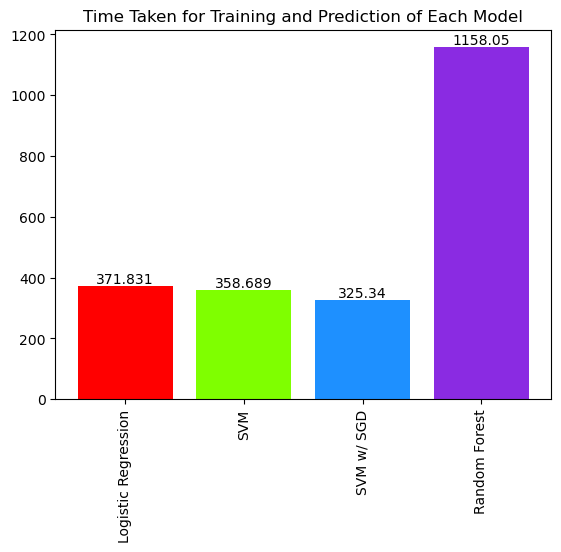

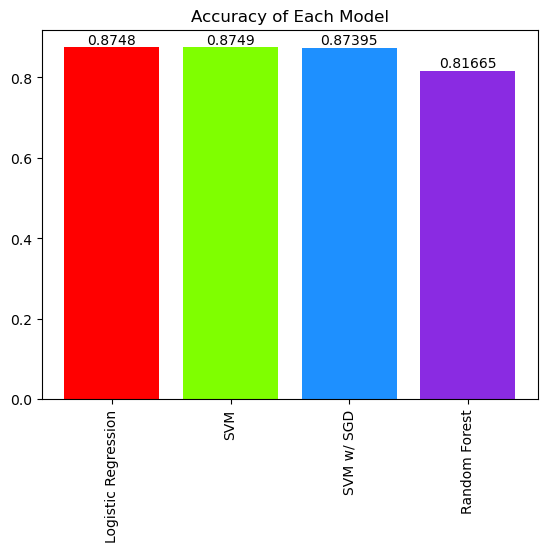

In [11]:
models = ['Logistic Regression', 'SVM', 'SVM w/ SGD', 'Random Forest']
colors = ['r', 'chartreuse', 'dodgerblue', 'blueviolet']

fig, ax = plt.subplots()
bars = ax.bar(models, times, color=colors)
ax.bar_label(bars)
plt.title("Time Taken for Training and Prediction of Each Model")
plt.xticks(rotation=90)
plt.show()

fig, ax = plt.subplots()
bars = ax.bar(models, accuracies, color=colors)
ax.bar_label(bars)
plt.title("Accuracy of Each Model")
plt.xticks(rotation=90)
plt.show()